## 1. Загрузка данных


### 1.1. Загрузите данные вашего варианта. Учтите, что метки классов являются текстом.


In [ ]:
import pandas as pd
import numpy as np

RS = 42
X = pd.read_csv('sample_data/lab4_3.csv')
X.head()

,X1,X2,Class
0,0.981214,4.666722,LEFT
1,0.579113,4.325803,LEFT
2,0.034151,4.326533,LEFT
3,0.189180,4.525031,LEFT
4,0.591636,4.827937,LEFT


In [ ]:
np.unique(X['Class'])

array(['LEFT', 'MID', 'RIGHT'], dtype=object)

In [ ]:
X['Class'].replace(['LEFT', 'MID', 'RIGHT'], [0, 1, 2], inplace=True)

In [ ]:
from scipy.stats import shapiro

columns = X.columns[:-1]
for i, column in enumerate(columns):
    print(f"column = {column} pvalue = {shapiro(X[column]).pvalue}")

column = X1 pvalue = 9.59514977694198e-07
column = X2 pvalue = 4.142718239563692e-07


### 1.2. Визуализируйте данные при помощи диаграммы рассеяния с выделением различных классов ней.


[Text(0.5, 1.0, 'Диаграмма рассеяния')]

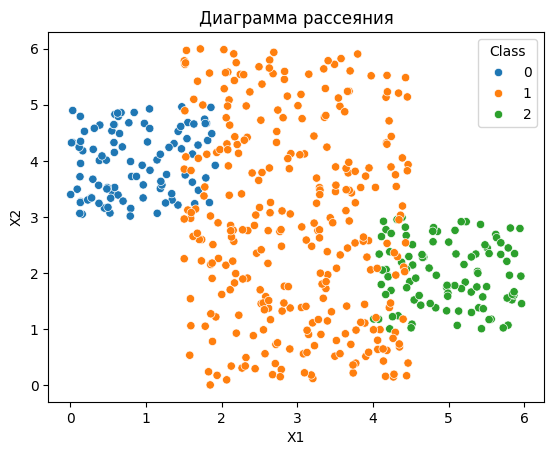

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=X['X1'], y=X['X2'], hue=X['Class'], palette='tab10').set(
    title='Диаграмма рассеяния'
)

### 1.3. Оцените сбалансированность классов


In [ ]:
print(f"Power of #1 class is {len(X[X['Class'] == 0])}")
print(f"Power of #2 class is {len(X[X['Class'] == 1])}")
print(f"Power of #3 class is {len(X[X['Class'] == 2])}")

Power of #1 class is 100
Power of #2 class is 300
Power of #3 class is 100


### 1.4. Проведите предобработку данных при необходимости

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      500 non-null    float64
 1   X2      500 non-null    float64
 2   Class   500 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 11.8 KB


Text(0.5, 0.98, 'Диаграммы boxplot для каждого признака')

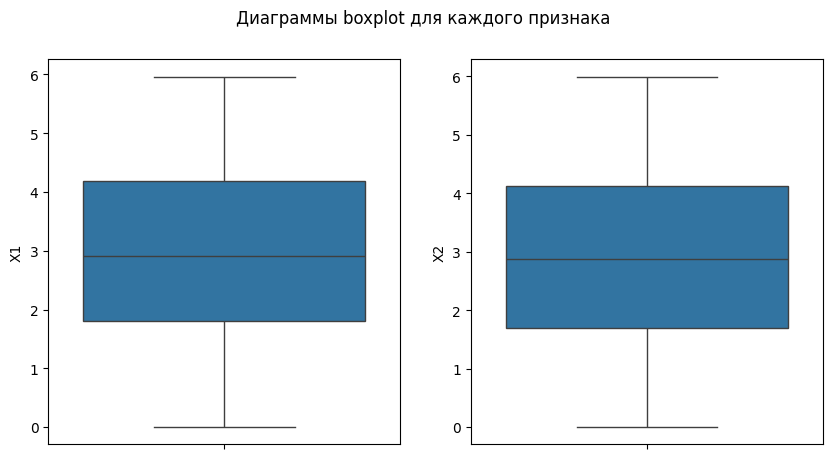

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.boxplot(X['X1'], ax=axes[0])
sns.boxplot(X['X2'], ax=axes[1])
fig.suptitle('Диаграммы boxplot для каждого признака')

### 1.5. Разделите выборку на обучающую и тестовую. На обучающей проводите обучение модели, на тестовой расчет значений метрик.


Так как в задачах классификации легко ошибиться с необходимостью применения стандартизации либо нормализации, поэтому далее наилучшие модели будут подбираться с учётом применяемого типа нормализации либо её отсутствия с помощью пайплайнов и кросс-валидации.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, :-1], X['Class'],
                                                    test_size=0.3,
                                                    random_state=RS)

## 2. KNN

### 2.1. Проведите классификацию методом k ближайших соседей, подобрав параметры: количество соседей, необходимость взвешивани. Постройте графики зависимости точности (Accuracy) в зависимости от количества соседей (по 1-й линии для взвешенного и не взвешенного метода)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
pipe = Pipeline(steps=[("scaler", None), ("knn", knn)])
param_grid = {
    "scaler": [MinMaxScaler(), StandardScaler(), 'passthrough'],
    "knn__n_neighbors": np.arange(1, 2*int(np.sqrt(len(X))), 1),
    "knn__weights": ['distance', 'uniform']
}
search = GridSearchCV(pipe, param_grid, scoring='balanced_accuracy')
search.fit(X_train, y_train)
search.best_params_

{'knn__n_neighbors': 8, 'knn__weights': 'distance', 'scaler': MinMaxScaler()}

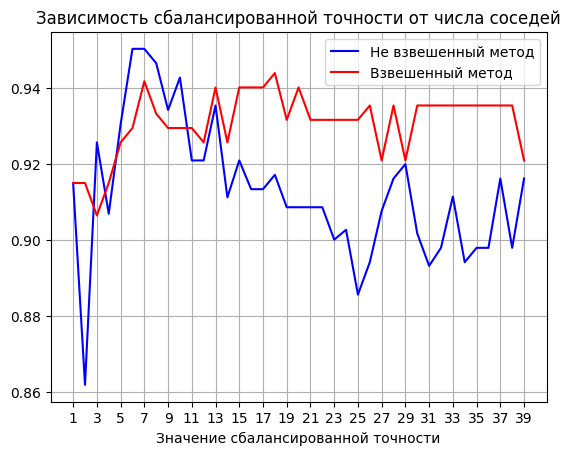

In [ ]:
from sklearn.metrics import balanced_accuracy_score


X_train_normal = MinMaxScaler().fit_transform(X_train)
X_test_normal = MinMaxScaler().fit_transform(X_test)
b_accur_uniform_list, b_accur_distance_list = [], []
for i in range(1, 40):
    knn_uniform = KNeighborsClassifier(n_neighbors=i, weights='uniform')
    knn_distance = KNeighborsClassifier(n_neighbors=i, weights='distance')
    knn_uniform.fit(X_train_normal, y_train)
    knn_distance.fit(X_train_normal, y_train)
    b_accur_uniform_list.append(balanced_accuracy_score(y_test,
                                              knn_uniform.predict(X_test_normal)))
    b_accur_distance_list.append(balanced_accuracy_score(y_test,
                                              knn_distance.predict(X_test_normal)))
plt.plot(np.arange(1, 40, 1), b_accur_uniform_list, c='blue', label='Не взвешенный метод')
plt.plot(np.arange(1, 40, 1), b_accur_distance_list, c='red', label='Взвешенный метод')
plt.title('Зависимость сбалансированной точности от числа соседей')
plt.xticks(np.arange(1, 40, 2))
plt.grid()
plt.legend()
plt.xlabel('Количество соседей')
plt.xlabel('Значение сбалансированной точности')
plt.show()

### 2.2. Постройте изображение с границами принятия решения ответив на них точки классов разным цветом. Сделайте выводы о качестве классификации на основе полученного изображения.


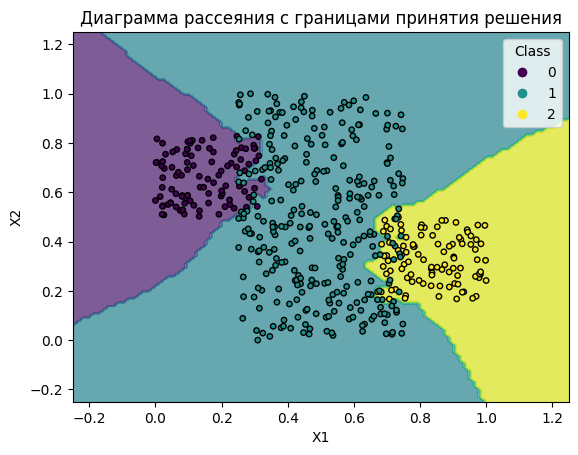

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay

def draw_decision_making_boundaries(estimator, X, X_train, y, x_lim, y_lim):
    display = DecisionBoundaryDisplay.from_estimator(
        estimator, X_train, response_method='predict',
        xlabel='X1', ylabel='X2',
        grid_resolution=200, alpha=0.7)
    scatter = display.ax_.scatter(X[:, 0], X[:, 1],
                                c=y, edgecolors='k', s=15)
    legend = plt.legend(handles=scatter.legend_elements()[0],
                        labels=['0', '1', '2'], title='Class')
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    plt.title('Диаграмма рассеяния с границами принятия решения')
    plt.show()

knn = KNeighborsClassifier(n_neighbors=8, weights='distance')
knn.fit(X_train_normal, y_train)
X_normal = MinMaxScaler().fit_transform(X.iloc[:, :-1])
models_info = {}
models_info['KNN'] = [balanced_accuracy_score(y_test, knn.predict(X_test_normal))]
draw_decision_making_boundaries(knn, X_normal, X_train_normal,
                                X['Class'], (-0.25, 1.25), (-0.25, 1.25))

### 2.3. Постройте таблицу ошибок для полученных результатов. Сделайте выводы о классификации на основе таблицы ошибок.


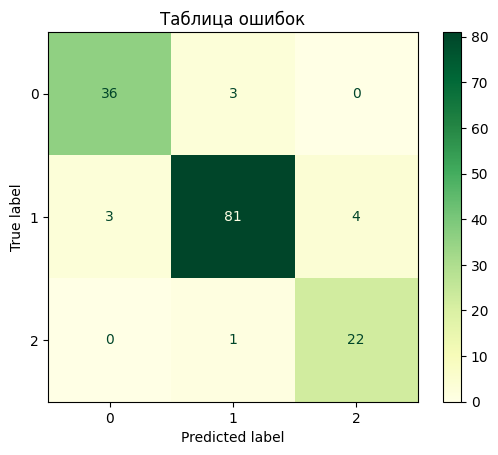

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

def print_error_matrix(estimator, X, y):
    ConfusionMatrixDisplay.from_estimator(estimator, X, y, cmap = 'YlGn')
    plt.title('Таблица ошибок')

print_error_matrix(knn, X_test_normal, y_test)

### 2.4. Рассчитайте значения Precision,Recall,F1 для полученных результатов. Сопоставьте с таблицей ошибок.


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

y_pred = knn.predict(X_test_normal)
print(f"(precision, recall, f1score) = {precision_recall_fscore_support(y_test, y_pred, average='macro')[:-1]}")

(precision, recall, f1score) = (0.9073906485671192, 0.9333510692206345, 0.9191507639071635)


In [ ]:
precision = (36 / (36 + 3) + 81 / (81 + 4) + 22 / (22 + 4)) / 3
recall = (36 / (36 + 3) + 81 / (81 + 7) + 22 / (22 + 1)) / 3
f1_1 = 2 * (36 / (36 + 3)) * (36 / (36 + 3)) / (2 * 36 / (36 + 3))
f1_2 = 2 * (81 / (81 + 4)) * (81 / (81 + 7)) / (81 / (81 + 4) + 81 / (81 + 7))
f1_3 = 2 * (22 / (22 + 4)) * (22 / (22 + 1)) / (22 / (22 + 4) + 22 / (22 + 1))
print(f"precision = {precision}")
print(f"recall = {recall}")
print(f"f1 = {(f1_1 + f1_2 + f1_3)/3}")
models_info['KNN'] += [precision, recall]

precision = 0.9073906485671192
recall = 0.9333510692206345
f1 = 0.9191507639071635


### 2.5. Постройте изображение ROC-кривой и рассчитайте значение AUC для полученных результатов. Сделайте выводы о классификации по полученному изображение и значению AUC.


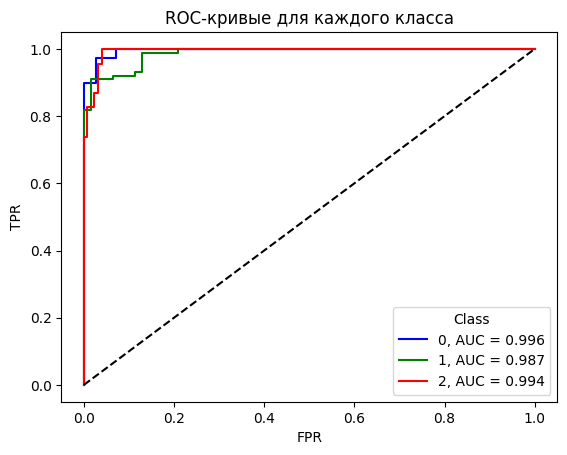

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

def print_roc_curve(estimator, X_test, y_test, estimator_name):
    fig = plt.Figure(figsize=(5, 5))
    y_score = estimator.predict_proba(X_test)
    colors = ['blue', 'green', 'red', 'orange']
    for i in range(max(y_test)+1):
        fpr, tpr, t = roc_curve(y_test == i, y_score[:, i])
        auc = roc_auc_score(y_test == i, y_score[:, i])
        models_info[estimator_name].append(auc)
        plt.plot(fpr, tpr, c=colors[i], label=f"{i}, AUC = {auc:.3f}")
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title(f"ROC-кривые для каждого класса")
    plt.plot([0, 1], [0, 1], color='black', linestyle='dashed')
    plt.legend(title="Class")
print_roc_curve(knn, X_test_normal, y_test, 'KNN')

## 3. Логистическая регрессия

### 3.1. Проведите классификацию методом логистической регрессии при различных параметрах: без регуляризации, с l1 регуляризацией, c l2 регуляризацией. Постройте столбчатую диаграмму зависимости точности (Accuracy) от наличия регуляризации. Дальнейшие пункты 3.* выполняйте для лучшего параметра.


In [ ]:
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

def log_reg_pipeline(penalty, solver, C, scaler, print_table=False):
    log_reg = LogisticRegression(penalty=None, random_state=RS)
    pipe = Pipeline(steps=[("scaler", None), ("log_reg", log_reg)])
    param_grid = {
        "scaler": scaler,
        "log_reg__solver": [solver],
        "log_reg__C": C,
        "log_reg__penalty": penalty
    }
    search = GridSearchCV(pipe, param_grid, scoring='balanced_accuracy')
    search.fit(X_train, y_train)
    if print_table:
        return search.cv_results_
    else:
        return search.best_params_, search.best_score_

In [ ]:
penalty_list = [['l2', None], ['l1', 'l2'], ['l2', None],
                ['l2', None],  ['l2', None], ['l1', 'l2', None]]
solver_list =  ['lbfgs', 'liblinear', 'newton-cg',
                'newton-cholesky', 'sag', 'saga']
C = [1e-10]
for i in range(1, 41):
    if i % 2 == 1:
        C.append(C[i-1]*5)
    else:
        C.append(C[i-1]*2)
scalers = [MinMaxScaler(), StandardScaler(), 'passthrough']
log_reg_models_info = np.array([log_reg_pipeline(
    penalty_list[i], solver_list[i], C, scalers) for i in range(len(solver_list))])
print(log_reg_models_info[np.argmax(log_reg_models_info[:, 1])])

[{'log_reg__C': 1e-10, 'log_reg__penalty': None, 'log_reg__solver': 'saga', 'scaler': MinMaxScaler()}
 0.8640107760456598]


In [ ]:
df = pd.DataFrame(log_reg_pipeline(penalty=['l1', 'l2', None], solver='saga',
                                   C=C, scaler=[MinMaxScaler()],
                                   print_table=True))
none_df = df[~df['param_log_reg__penalty'].isin(['l1', 'l2'])].sort_values(
    by='mean_test_score', ascending=False).head(1)
l1_df = df[df['param_log_reg__penalty'] == 'l1'].sort_values(
    by='mean_test_score', ascending=False).head(1)
l2_df = df[df['param_log_reg__penalty'] == 'l2'].sort_values(
    by='mean_test_score', ascending=False).head(1)
pd.concat([none_df[['param_log_reg__penalty', 'mean_test_score', 'param_log_reg__C']],
           l1_df[['param_log_reg__penalty', 'mean_test_score', 'param_log_reg__C']],
           l2_df[['param_log_reg__penalty', 'mean_test_score', 'param_log_reg__C']]])

,param_log_reg__penalty,mean_test_score,param_log_reg__C
2,None,0.864011,0.0
120,l1,0.864011,10000000000.0
121,l2,0.864011,10000000000.0


Text(0, 0.5, 'Точность')

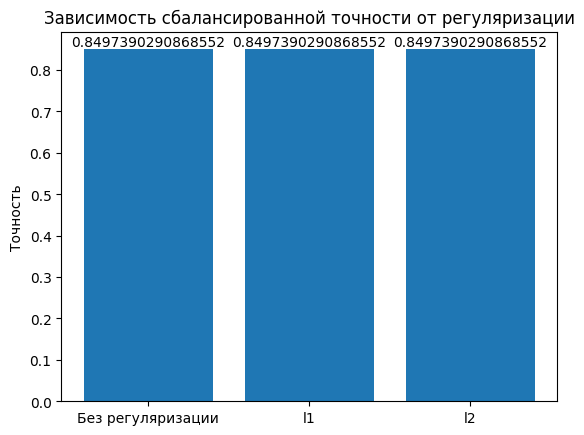

In [ ]:
log_reg_l1 = LogisticRegression(penalty='l1', C=10000000000.0, solver='saga')
log_reg_l1.fit(X_train_normal, y_train)
log_reg_l2 = LogisticRegression(penalty='l2', C=10000000000.0, solver='saga')
log_reg_l2.fit(X_train_normal, y_train)
log_reg = LogisticRegression(penalty=None, solver='saga')
log_reg.fit(X_train_normal, y_train)
b_accur = [balanced_accuracy_score(y_test, log_reg.predict(X_test_normal)),
           balanced_accuracy_score(y_test, log_reg_l1.predict(X_test_normal)),
           balanced_accuracy_score(y_test, log_reg_l2.predict(X_test_normal))]
names = ['Без регуляризации', 'l1', 'l2']
plt.bar(names, b_accur)
for i in range(len(names)):
    plt.text(i, b_accur[i], str(b_accur[i]), ha='center', va='bottom')
plt.title('Зависимость сбалансированной точности от регуляризации')
plt.ylabel('Точность')

### 3.2. Постройте изображение с границами принятия решения ответив на них точки классов разным цветом. Сделайте выводы о качестве классификации на основе полученного изображения.


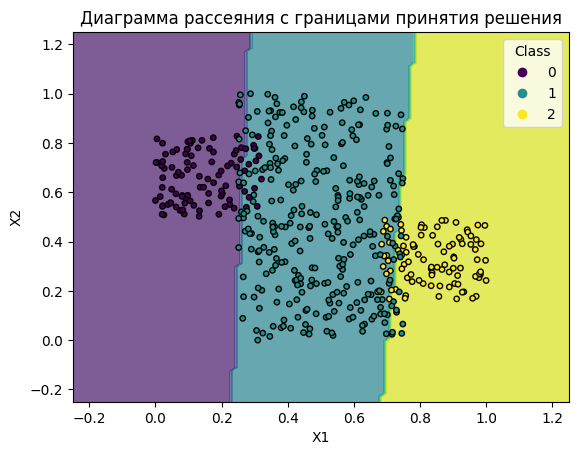

In [ ]:
models_info['LogisticRegression'] = [balanced_accuracy_score(y_test, log_reg.predict(X_test_normal))]
draw_decision_making_boundaries(log_reg, X_normal, X_test_normal, X['Class'],
                                (-0.25, 1.25), (-0.25, 1.25))

### 3.3. Постройте таблицу ошибок для полученных результатов. Сделайте выводы о классификации на основе таблицы ошибок.


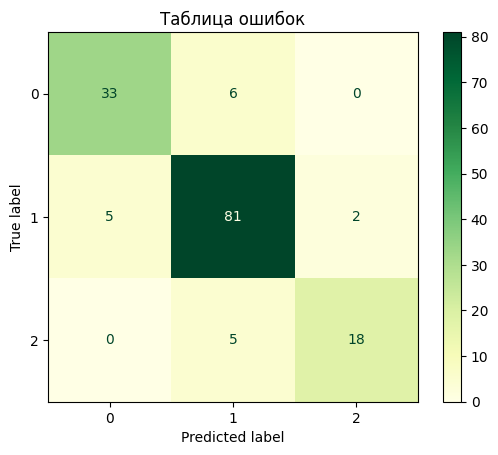

In [ ]:
print_error_matrix(log_reg, X_test_normal, y_test)

### 3.4. Рассчитайте значения Precision,Recall,F1 для полученных результатов. Сопоставьте с таблицей ошибок.


In [ ]:
y_pred = log_reg.predict(X_test_normal)
print(f"(precision, recall, f1score) = {precision_recall_fscore_support(y_test, y_pred, average='macro')[:-1]}")

(precision, recall, f1score) = (0.8829519450800914, 0.8497390290868552, 0.8647840531561463)


In [ ]:
precision = (33 / (33 + 5) + 81 / (81 + 11) + 18 / (18 + 2)) / 3
recall = (33 / (33 + 6) + 81 / (81 + 7) + 18 / (18 + 5)) / 3
f1_1 = 2 * (33 / (33 + 5)) * (33 / (33 + 6)) / (33 / (33 + 5) + 33 / (33 + 6))
f1_2 = 2 * (81 / (81 + 11)) * (81 / (81 + 7)) / (81 / (81 + 11) + 81 / (81 + 7))
f1_3 = 2 * (18 / (18 + 2)) * (18 / (18 + 5)) / (18 / (18 + 2) + 18 / (18 + 5))
print(f"precision = {precision}")
print(f"recall = {recall}")
print(f"f1 = {(f1_1 + f1_2 + f1_3)/3}")
models_info['LogisticRegression'] += [precision, recall]

precision = 0.8829519450800914
recall = 0.8497390290868552
f1 = 0.8647840531561463


### 3.5. Постройте изображение ROC-кривой и рассчитайте значение AUC для полученных результатов. Сделайте выводы о классификации по полученному изображение и значению AUC.


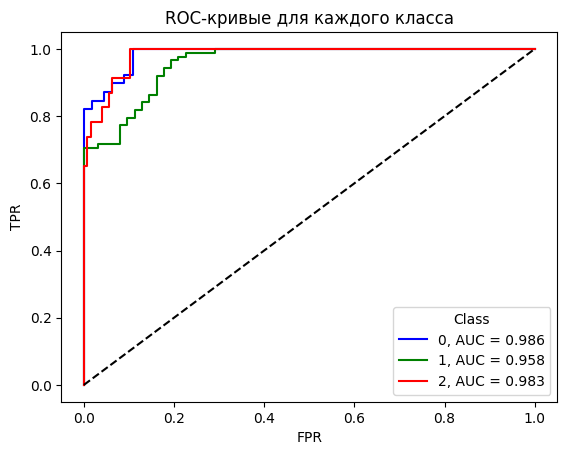

In [ ]:
print_roc_curve(log_reg, X_test_normal, y_test, 'LogisticRegression')

## 4. Метод опорных векторов


### 4.1. Проведите классификацию методом опорных векторах при различных параметрах ядра: “linear”, “poly” (нужно выбрать степень), “rbf”. Постройте столбчатую диаграмму зависимости точности (Accuracy) от вида ядра. Дальнейшие пункты 4.* выполняйте для лучшего параметра.


In [ ]:
from sklearn.svm import SVC

svc = SVC(random_state=RS)
pipe = Pipeline(steps=[("scaler", None), ("svc", svc)])
d = []
for i in range(2, 9):
    d.append(i)
param_grid = {
    "scaler": scalers,
    "svc__kernel": ['linear', 'poly', 'rbf'],
    "svc__degree": d
}
search = GridSearchCV(pipe, param_grid, scoring='balanced_accuracy')
search.fit(X_train, y_train)
print(search.best_params_)

{'scaler': 'passthrough', 'svc__degree': 5, 'svc__kernel': 'poly'}


In [ ]:
df = pd.DataFrame(search.cv_results_)
poly_df = df[df['param_svc__kernel'] == 'poly'].sort_values(
    by='mean_test_score', ascending=False).head(1)
rbf_df = df[df['param_svc__kernel'] == 'rbf'].sort_values(
    by='mean_test_score', ascending=False).head(1)
linear_df = df[df['param_svc__kernel'] == 'linear'].sort_values(
    by='mean_test_score', ascending=False).head(1)
pd.concat([poly_df[['param_svc__kernel', 'mean_test_score']],
           rbf_df[['param_svc__kernel', 'mean_test_score']],
           linear_df[['param_svc__kernel', 'mean_test_score']]])

,param_svc__kernel,mean_test_score
52,poly,0.912050
2,rbf,0.911964
60,linear,0.849820


Text(0, 0.5, 'Точность')

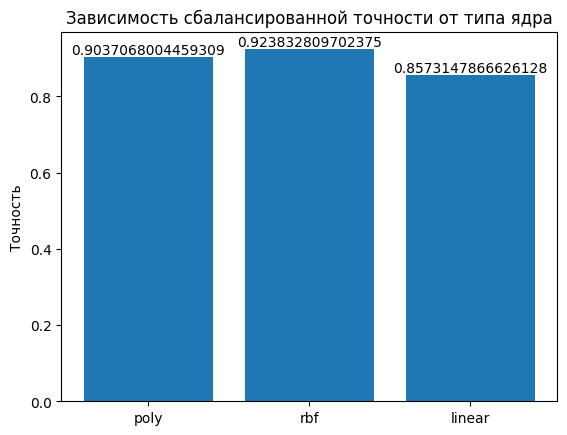

In [ ]:
svc_poly = SVC(kernel='poly', degree=5, probability=True)
svc_poly.fit(X_train, y_train)
svc_rbf = SVC(kernel='rbf')
svc_rbf.fit(X_train, y_train)
svc_linear = SVC(kernel='linear', degree=5)
svc_linear.fit(X_train, y_train)
b_accur = [balanced_accuracy_score(y_test, svc_poly.predict(X_test)),
           balanced_accuracy_score(y_test, svc_rbf.predict(X_test)),
           balanced_accuracy_score(y_test, svc_linear.predict(X_test))]
names = ['poly', 'rbf', 'linear']
plt.bar(names, b_accur)
for i in range(len(names)):
    plt.text(i, b_accur[i], str(b_accur[i]), ha='center', va='bottom')
plt.title('Зависимость сбалансированной точности от типа ядра')
plt.ylabel('Точность')

### 4.2. Постройте изображение с границами принятия решения ответив на них точки классов разным цветом. Сделайте выводы о качестве классификации на основе полученного изображения.


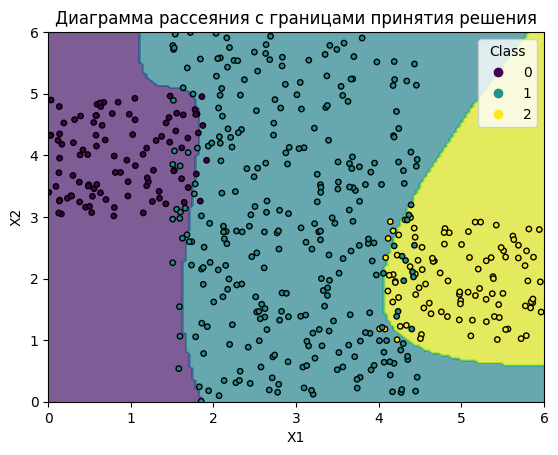

In [ ]:
models_info['SVC'] = [balanced_accuracy_score(y_test, svc_poly.predict(X_test))]
draw_decision_making_boundaries(svc_poly, X.iloc[:, :-1].to_numpy(), X_train,
                                X['Class'], (0, 6), (0, 6))

### 4.3. Постройте таблицу ошибок для полученных результатов. Сделайте выводы о классификации на основе таблицы ошибок.


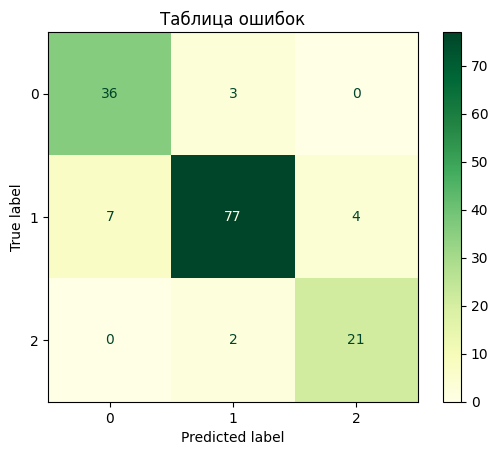

In [ ]:
print_error_matrix(svc_poly, X_test, y_test)

### 4.4. Рассчитайте значения Precision,Recall,F1 для полученных результатов. Сопоставьте с таблицей ошибок.


In [ ]:
y_pred = svc_poly.predict(X_test)
print(f"(precision, recall, f1score) = {precision_recall_fscore_support(y_test, y_pred, average='macro')[:-1]}")

(precision, recall, f1score) = (0.8720778975231612, 0.9037068004459309, 0.8863103778096604)


In [ ]:
precision = (36 / (36 + 7) + 77 / (77 + 5) + 21 / (21 + 4)) / 3
recall = (36 / (36 + 3) + 77 / (77 + 11) + 21 / (21 + 2)) / 3
f1_1 = 2 * (36 / (36 + 7)) * (36 / (36 + 3)) / (36 / (36 + 7) + 36 / (36 + 3))
f1_2 = 2 * (77 / (77 + 5)) * (77 / (77 + 11)) / (77 / (77 + 5) + 77 / (77 + 11))
f1_3 = 2 * (21 / (21 + 4)) * (21 / (21 + 2)) / (21 / (21 + 2) + 21 / (21 + 4))
print(f"precision = {precision}")
print(f"recall = {recall}")
print(f"f1 = {(f1_1 + f1_2 + f1_3) / 3}")
models_info['SVC'] += [precision, recall]

precision = 0.8720778975231612
recall = 0.9037068004459309
f1 = 0.8863103778096604


### 4.5. Постройте изображение ROC-кривой и рассчитайте значение AUC для полученных результатов. Сделайте выводы о классификации по полученному изображение и значению AUC.


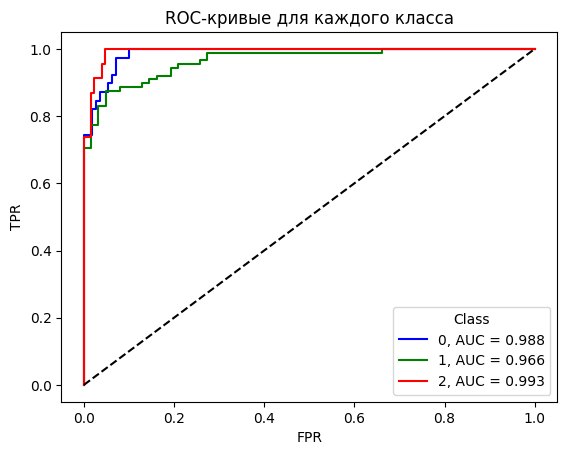

In [ ]:
print_roc_curve(svc_poly, X_test, y_test, 'SVC')

## 5. Решающие деревья


### 5.1. Проведите классификацию используя решающие деревья, подобрав параметры при которых получается лучшее обобщение (максимальная глубина/максимальное количество листьев/метрика загрязнения и т.д.).


In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

dtc = DecisionTreeClassifier(random_state=RS, max_leaf_nodes=3,
                             min_samples_leaf=50)
pipe = Pipeline(steps=[("scaler", None), ("dtc", dtc)])
param_grid = {
    "scaler": scalers,
    "dtc__min_samples_split": np.arange(50, 300, dtype=int),
    "dtc__criterion": ['gini', 'entropy', 'log_loss']
}
search = GridSearchCV(pipe, param_grid, scoring='balanced_accuracy')
search.fit(X_train, y_train)
print(search.best_params_)
print(f"balanced accurancy = {search.best_score_}")

{'dtc__criterion': 'entropy', 'dtc__min_samples_split': 50, 'scaler': MinMaxScaler()}
balanced accurancy = 0.8997268364710225


In [ ]:
dtc = DecisionTreeClassifier(criterion='entropy',
                             min_samples_split=50,
                             min_samples_leaf=50,
                             max_leaf_nodes=3,
                             random_state=RS)
dtc.fit(X_train_normal, y_train)

DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=3,
                       min_samples_leaf=50, min_samples_split=50,
                       random_state=42)

### 5.2. Постройте изображение с границами принятия решения ответив на них точки классов разным цветом. Сделайте выводы о качестве классификации на основе полученного изображения.


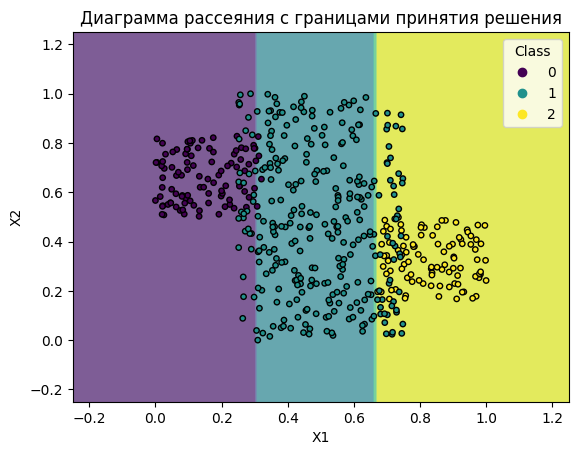

In [ ]:
models_info['DecisionTreeClassifier'] = [balanced_accuracy_score(y_test, dtc.predict(X_test_normal))]
draw_decision_making_boundaries(dtc, X_normal, X_test_normal,
                                X['Class'], (-0.25, 1.25), (-0.25, 1.25))

### 5.3. Постройте таблицу ошибок для полученных результатов. Сделайте выводы о классификации на основе таблицы ошибок.


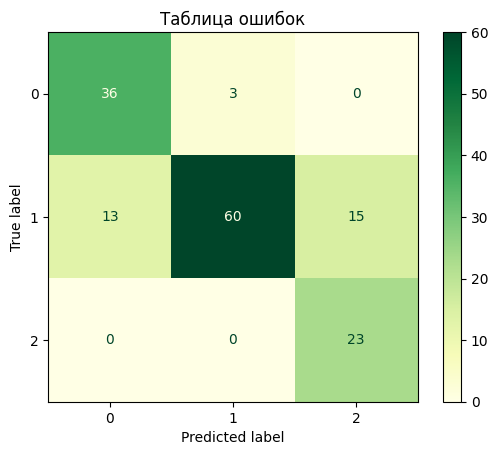

In [ ]:
print_error_matrix(dtc, X_test_normal, y_test)

### 5.4. Рассчитайте значения Precision,Recall,F1 для полученных результатов. Сопоставьте с таблицей ошибок.


In [ ]:
y_pred = dtc.predict(X_test_normal)
print(f"(precision, recall, f1score) = {precision_recall_fscore_support(y_test, y_pred, average='macro')[:-1]}")

(precision, recall, f1score) = (0.7641126626089032, 0.8682983682983684, 0.7889940551975075)


In [ ]:
precision = (36 / (36 + 13) + 60 / (60 + 3) + 23 / (23 + 15)) / 3
recall = (36 / (36 + 3) + 60 / (60 + 28) + 23 / (23)) / 3
f1_1 = 2 * (36 / (36 + 13)) * (36 / (36 + 3)) / (36 / (36 + 13) + 36 / (36 + 3))
f1_2 = 2 * (60 / (60 + 3)) * (60 / (60 + 28)) / (60 / (60 + 3) + 60 / (60 + 28))
f1_3 = 2 * (23 / (23 + 15)) * (23 / (23)) / (23 / (23 + 15) + 23 / (23))
print(f"precision = {precision}")
print(f"recall = {recall}")
print(f"f1 = {(f1_1 + f1_2 + f1_3) / 3}")
models_info['DecisionTreeClassifier'] += [precision, recall]

precision = 0.7641126626089032
recall = 0.8682983682983684
f1 = 0.7889940551975075


### 5.5. Постройте изображение ROC-кривой и рассчитайте значение AUC для полученных результатов. Сделайте выводы о классификации по полученному изображение и значению AUC.


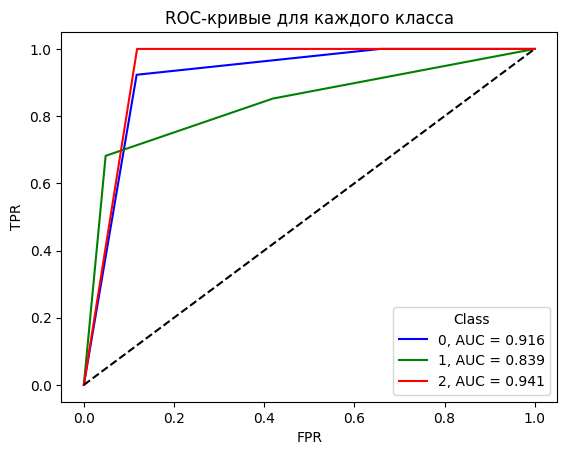

In [ ]:
print_roc_curve(dtc, X_test_normal, y_test, 'DecisionTreeClassifier')

### 5.6. Визуализируйте полученное дерево решений. Сделайте выводы о правилах в узлах дерева. Сопоставьте их с полученными границами принятия решений.


Text(0.5, 1.0, 'Дерево решений')

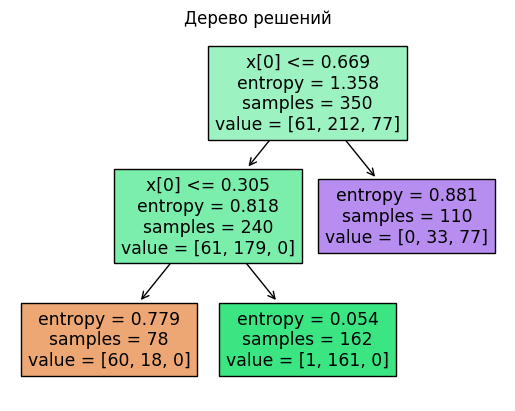

In [ ]:
plot_tree(dtc, filled=True)
plt.title('Дерево решений')

## 6. Выбор классификатора

### 6.1. Постройте таблицу с метриками Precision, Recall, AUC для полученных результатов каждым классификатором.


In [ ]:
models_info_pd = pd.DataFrame(models_info, index=['b_accurancy', 'precision', 'recall',
                                                    'auc #1', 'auc #2', 'auc #3']).T
models_info_pd

,b_accurancy,precision,recall,auc #1,auc #2,auc #3
KNN,0.933351,0.907391,0.933351,0.996073,0.986804,0.993838
LogisticRegression,0.849739,0.882952,0.849739,0.986140,0.958211,0.982883
SVC,0.903707,0.872078,0.903707,0.987757,0.965543,0.993153
DecisionTreeClassifier,0.868298,0.764113,0.868298,0.916147,0.838801,0.940945


### 6.2. Сделайте выводы о том, какие классификаторы лучше всего подходят для вашего набора данных и в каких случаях.
